In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import yfinance as yf


In [3]:
def get_pair(name):
    curr = yf.Ticker(name)
    hist = curr.history(period = 'max')
    return (hist)

In [4]:
df = get_pair('ULVR.L') #data pull
df.reset_index(inplace = True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1988-07-01,483.50,483.50,483.50,483.50,0,0.0,0.0
1,1988-07-04,487.12,487.12,487.12,487.12,0,0.0,0.0
2,1988-07-05,485.05,485.05,485.05,485.05,0,0.0,0.0
3,1988-07-06,496.47,496.47,496.47,496.47,0,0.0,0.0
4,1988-07-07,493.36,493.36,493.36,493.36,0,0.0,0.0
...,...,...,...,...,...,...,...,...
8326,2020-12-07,4360.00,4390.00,4302.84,4335.00,5721332,0.0,0.0
8327,2020-12-08,4332.00,4358.00,4279.00,4354.00,7942697,0.0,0.0
8328,2020-12-09,4379.00,4394.00,4269.00,4352.00,10518285,0.0,0.0
8329,2020-12-10,4400.00,4434.00,4366.00,4395.00,7184914,0.0,0.0


In [9]:
stock = get_pair('^FTSE') #data pull
stock.reset_index(inplace = True)
stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1984-01-03,997.5,1001.4,997.5,997.5,0,0,0
1,1984-01-04,997.5,999.5,993.3,998.6,0,0,0
2,1984-01-05,1007.1,1015.8,1007.1,1015.8,0,0,0
3,1984-01-06,1019.0,1029.3,1019.0,1029.0,0,0,0
4,1984-01-09,1030.6,1035.4,1030.6,1034.6,0,0,0
...,...,...,...,...,...,...,...,...
9399,2020-12-07,6550.2,6601.1,6519.8,6555.4,1058250500,0,0
9400,2020-12-08,6555.4,6567.6,6518.4,6558.8,758186800,0,0
9401,2020-12-09,6558.8,6623.0,6558.8,6564.3,769345300,0,0
9402,2020-12-10,6564.3,6640.7,6561.1,6599.8,1109877200,0,0


In [10]:
d2 = pd.merge(df, stock, on = 'Date', how = 'inner')
d2 = d2[['Date','Close_x','Close_y']]
d2.columns = ['Date', 'Unilever', 'FTSE']
d2

,Date,Unilever,FTSE
0,1988-07-01,483.50,1858.2
1,1988-07-04,487.12,1848.0
2,1988-07-05,485.05,1854.8
3,1988-07-06,496.47,1870.0
4,1988-07-07,493.36,1855.5
...,...,...,...
8234,2020-12-07,4335.00,6555.4
8235,2020-12-08,4354.00,6558.8
8236,2020-12-09,4352.00,6564.3
8237,2020-12-10,4395.00,6599.8


In [11]:
def plotter(df, x, y): 
    plt.figure(figsize = (20,10))
    for i in range(0, len(y)):
        plt.plot(df[x], df[y[i]], label = y[i])
    plt.grid()
    plt.legend()
    plt.show()

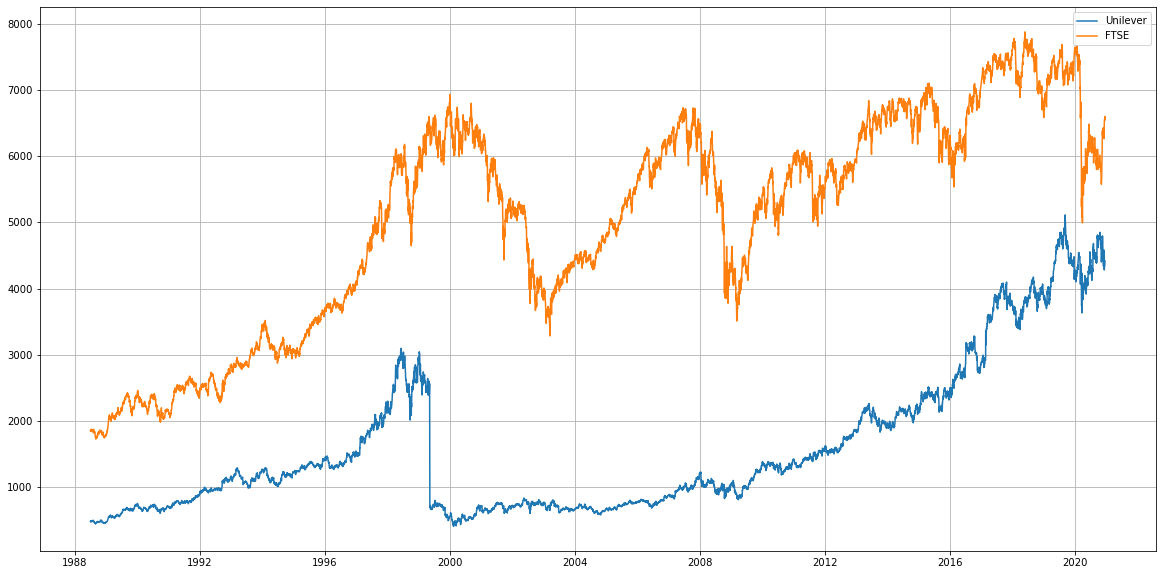

In [12]:
pair = d2
plotter(pair, 'Date', ['Unilever','FTSE'])

In [13]:
def gen_z_score(lookback, df, on_column): 
    df["Mean"] = df[on_column].rolling(lookback).mean()
    df["Std"] = df[on_column].rolling(lookback).std()
    df[on_column + " Z Score"] = (df[on_column] - df["Mean"])/df["Std"]
    return(df)

In [15]:
pair['Diff'] = pair['Unilever'] - pair['FTSE']
pair_z = gen_z_score(30, pair, 'Diff')

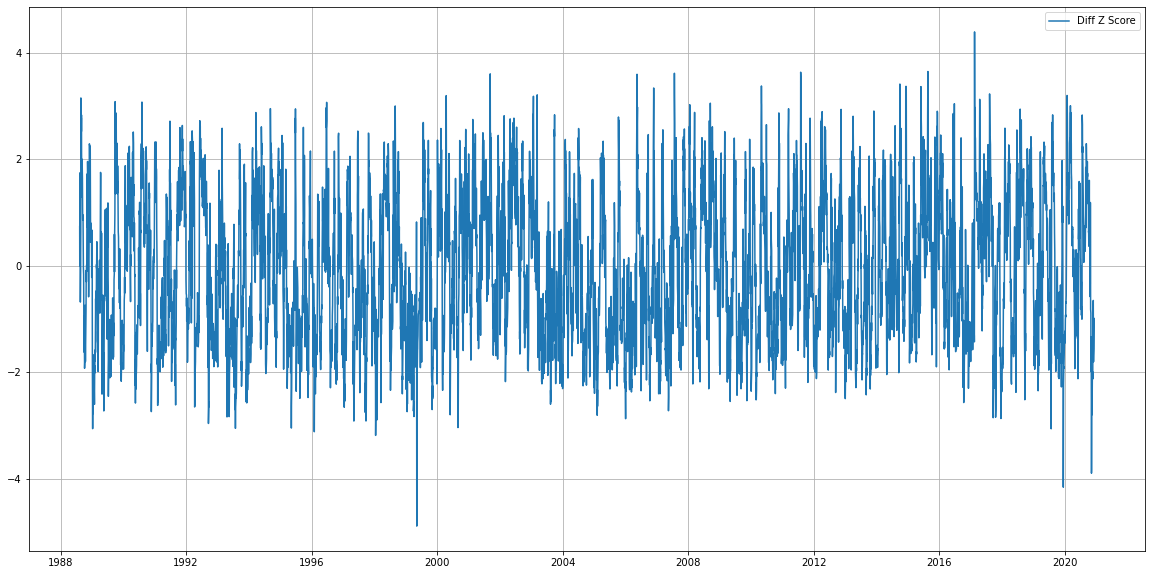

In [16]:
plotter(pair_z, 'Date', ['Diff Z Score'])

In [17]:


def backtesterV2(backtest, entry, z_key, underlying_key):
    backtest.reset_index(inplace = True, drop = True)
    backtest['Pos'] = 0 
    backtest['Tick PnL'] = 0
    backtest['Tick Change'] = backtest[underlying_key].diff()


    for i in range(1, len(backtest)): 
        if backtest.iloc[i][z_key] > entry: 
            backtest.loc[i, 'Pos'] = -1
        elif backtest.iloc[i][z_key] < -entry: 
            backtest.loc[i, 'Pos'] = 1


        if backtest.iloc[i-1]['Pos'] != 0: 
            backtest.loc[i,'Tick PnL'] = backtest.iloc[i]['Pos']*backtest.iloc[i]['Tick Change'] + (backtest.iloc[i-1]['Pos'] - backtest.iloc[i]['Pos'])* backtest.iloc[i]['Tick Change']

    backtest['Cum PnL'] = backtest['Tick PnL'].cumsum()
    
    return(backtest)

In [18]:
def backtester(backtest, entry, z_key, underlying_key):
    backtest["Position"] = 0
    mask = backtest[z_key] >= entry
    backtest.loc[mask, "Position"] = 1 
    mask2 = backtest[z_key] <= -entry
    backtest.loc[mask2, "Position"] = -1 

    backtest["Tick Change"] = backtest[underlying_key].diff(1)
    backtest["Tick PnL"] = backtest["Tick Change"] * backtest["Position"]
    backtest["Cum PnL"] = backtest["Tick PnL"].cumsum()
    
    return(backtest)


<ipython-input-17-fabadffdb663>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['Pos'] = 0
<ipython-input-17-fabadffdb663>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['Tick PnL'] = 0
<ipython-input-17-fabadffdb663>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

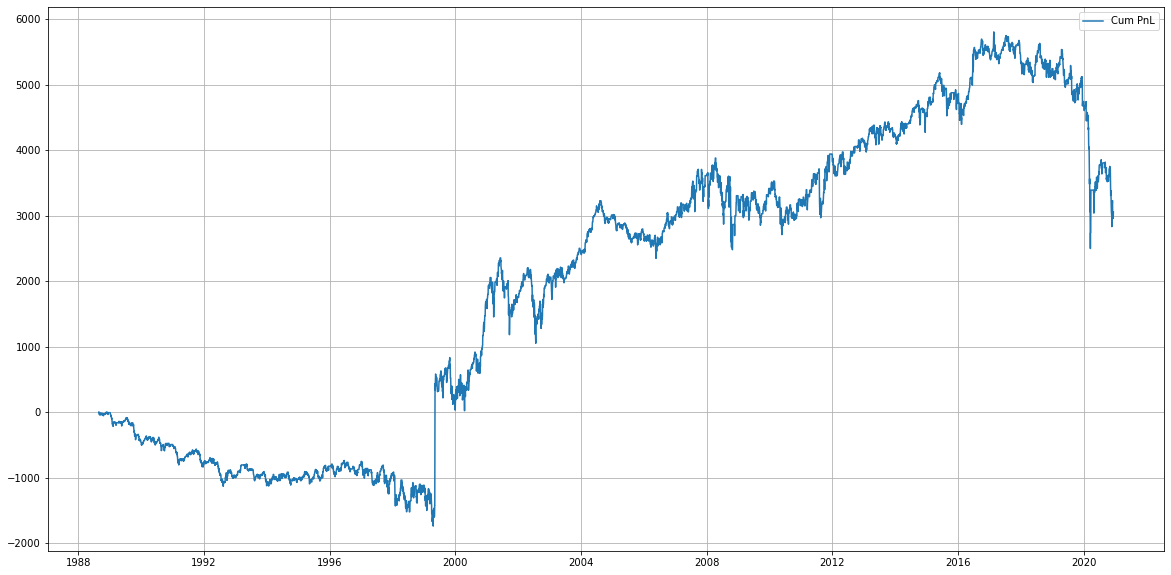

In [23]:
btest = backtesterV2(pair_z[40:], 0.8, 'Diff Z Score', 'Diff')
plotter(btest, 'Date', ['Cum PnL'])

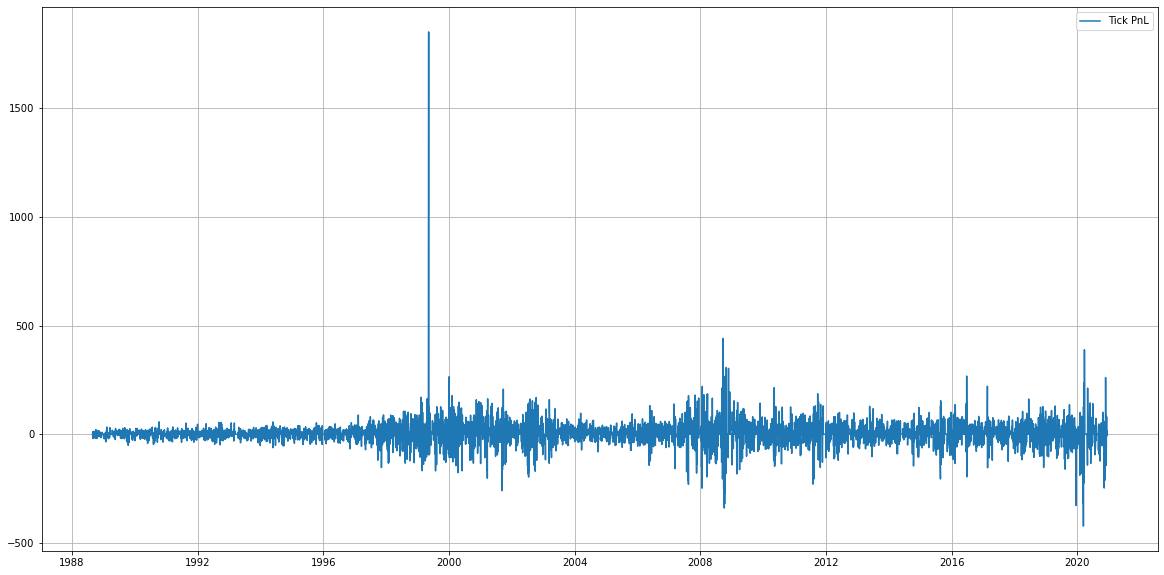

In [24]:
plotter(btest, 'Date',['Tick PnL'])

In [25]:
pair_z

,Date,Unilever,FTSE,Diff,Mean,Std,Diff Z Score
0,1988-07-01,483.50,1858.2,-1374.70,NaN,NaN,NaN
1,1988-07-04,487.12,1848.0,-1360.88,NaN,NaN,NaN
2,1988-07-05,485.05,1854.8,-1369.75,NaN,NaN,NaN
3,1988-07-06,496.47,1870.0,-1373.53,NaN,NaN,NaN
4,1988-07-07,493.36,1855.5,-1362.14,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8234,2020-12-07,4335.00,6555.4,-2220.40,-1645.214667,368.564707,-1.560609
8235,2020-12-08,4354.00,6558.8,-2204.80,-1682.752000,366.213666,-1.425528
8236,2020-12-09,4352.00,6564.3,-2212.30,-1720.520000,360.205251,-1.365277
8237,2020-12-10,4395.00,6599.8,-2204.80,-1756.720000,352.128201,-1.272491


In [26]:
btest.describe()

,Unilever,FTSE,Diff,Mean,Std,Diff Z Score,Pos,Tick PnL,Tick Change,Cum PnL
count,8199.000000,8199.000000,8199.000000,8199.000000,8199.000000,8199.000000,8199.000000,8199.000000,8198.000000,8199.000000
mean,1599.724357,5046.571057,-3446.846701,-3445.761551,89.759466,-0.085236,0.070618,0.372491,-0.099064,2000.201289
std,1113.368705,1618.360495,1289.395992,1285.927221,71.225140,1.333048,0.804060,46.042113,54.207715,2292.683356
min,416.100000,1730.500000,-6363.590000,-6127.619667,10.923959,-4.890217,-1.000000,-422.450000,-1851.020000,-1741.070000
25%,748.310000,3744.250000,-4431.330000,-4425.500500,44.869720,-1.191926,-1.000000,-8.660000,-22.557500,-624.430000
50%,1192.660000,5422.400000,-3607.920000,-3614.757333,72.947780,-0.221631,0.000000,0.000000,-0.630000,2646.430000
75%,2121.365000,6315.450000,-2216.365000,-2204.188500,115.240384,0.979777,1.000000,8.795000,21.297500,3790.680000
max,5114.680000,7877.500000,-917.180000,-1137.153333,829.424420,4.387555,1.000000,1851.020000,422.450000,5806.500000


In [18]:
(342.06-122.14)

219.92000000000002

In [19]:
219.92-205.609

14.310999999999979

In [20]:
14.31099999/8.855

1.6161490671936758